In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
%cd "/content/gdrive/MyDrive/Text Matching/"

/content/gdrive/MyDrive/Text Matching


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
import re

dataset = pd.read_csv("clean_data")
dataset.head()

,搜索ID,语义1,语义2,匹配与否
0,0,事故住建厅通报福建一工地发生坍塌事故致死伤,突发广元一隧道内发生三车相撞事故致死伤,0
1,1,抢险牺牲山东莒县村干部孟凡勇没来得及和家人拍全家福,利奇马席卷山东铝企抢险实况,0
2,2,张云雷刚退赛欢乐喜剧人就贴上歌手标签要转行的节奏,欢乐喜剧人我是歌手,1
3,3,这个台湾省爱国教育基地被强拆前再一次升起了五星红旗,台湾升起五星红旗,1
4,4,微博能发张图片了想晒库存仅对粉丝数大于万的用户开放,发一个库存喜欢女儿笑你笑起来真好看,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673058 entries, 0 to 673057
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   搜索ID    673058 non-null  int64 
 1   语义1     673058 non-null  object
 2   语义2     673058 non-null  object
 3   匹配与否    673058 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 20.5+ MB


In [5]:
def jieba_tokenize(sentence):
    return " ".join([word for word in jieba.cut(sentence)])

dataset["语义1"] = dataset["语义1"].apply(jieba_tokenize)
dataset["语义2"] = dataset["语义2"].apply(jieba_tokenize)
dataset.head()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.663 seconds.
Prefix dict has been built successfully.


,搜索ID,语义1,语义2,匹配与否
0,0,事故 住 建厅 通报 福建 一 工地 发生 坍塌 事故 致 死伤,突发 广元 一 隧道 内 发生 三 车 相撞 事故 致 死伤,0
1,1,抢险 牺牲 山东 莒县 村干部 孟凡勇 没 来得及 和 家人 拍 全家福,利奇马 席卷 山东 铝企 抢险 实况,0
2,2,张云雷刚 退赛 欢乐 喜剧 人 就 贴 上 歌手 标签 要 转行 的 节奏,欢乐 喜剧 人 我 是 歌手,1
3,3,这个 台湾省 爱国 教育 基地 被 强拆 前 再 一次 升起 了 五星红旗,台湾 升起 五星红旗,1
4,4,微博能 发张 图片 了 想 晒 库存 仅 对 粉丝 数 大于 万 的 用户 开放,发 一个 库存 喜欢 女儿 笑 你 笑 起来 真 好看,0


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

data1, data2, label = dataset["语义1"], dataset["语义2"], dataset["匹配与否"].values
whole_data = pd.concat([data1, data2], axis=0).values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(whole_data)
sequences1 = tokenizer.texts_to_sequences(data1.values)
sequences2 = tokenizer.texts_to_sequences(data2.values)
pad_data1 = pad_sequences(sequences1, maxlen=20)
pad_data2 = pad_sequences(sequences2, maxlen=20)
print('Shape of pad_data1:', pad_data1.shape)
print('Shape of pad_data2:', pad_data2.shape)
print('Shape of label:', label.shape)

Shape of pad_data1: (673058, 20)
Shape of pad_data2: (673058, 20)
Shape of label: (673058,)


In [7]:
from sklearn.model_selection import train_test_split

train_X1, valid_test_X1, train_y1, valid_test_y1 = train_test_split(pad_data1, label, test_size=0.1, stratify=label, random_state=42)
train_X2, valid_test_X2, train_y2, valid_test_y2 = train_test_split(pad_data2, label, test_size=0.1, stratify=label, random_state=42)
print('shape of train_X1:', train_X1.shape)
print('shape of valid_test_X1:', valid_test_X1.shape)
print('shape of train_y1:', train_y1.shape)
print('shape of valid_test_y1:', valid_test_y1.shape)

shape of train_X1: (605752, 20)
shape of valid_test_X1: (67306, 20)
shape of train_y1: (605752,)
shape of valid_test_y1: (67306,)


In [8]:
valid_X1, test_X1, valid_y1, test_y1 = train_test_split(valid_test_X1, valid_test_y1, test_size=0.5, stratify=valid_test_y1, random_state=42)
valid_X2, test_X2, valid_y2, test_y2 = train_test_split(valid_test_X2, valid_test_y2, test_size=0.5, stratify=valid_test_y2, random_state=42)
print('shape of valid_X1:', valid_X1.shape)
print('shape of test_X1:', test_X1.shape)
print('shape of valid_y1:', valid_y1.shape)
print('shape of test_y1:', test_y1.shape)

shape of valid_X1: (33653, 20)
shape of test_X1: (33653, 20)
shape of valid_y1: (33653,)
shape of test_y1: (33653,)


In [9]:
embeddings_table = {}
with open('100000-small.txt','r') as file:
  for row_index, line in enumerate(file):
    if row_index == 0:
      continue
    row_data = line.split()
    word = row_data[0]
    vector = np.array(row_data[1:], dtype='float32')
    embeddings_table[word] = vector

In [10]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_SIZE = 200

word_index = tokenizer.word_index
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_SIZE))
for word, index in word_index.items():
  embedding_vector = embeddings_table.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [11]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):

    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

    def get_config(self):
      base_config = super(Attention, self).get_config().copy()
      base_config.update({
            'return_sequences': self.return_sequences,
            })
      return base_config

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Dot
from tensorflow.keras.layers import Embedding, GRU, Bidirectional

OUTPUT_DIM = 32
MAX_LENGTH = 20

input1 = Input(shape=[MAX_LENGTH])
input2 = Input(shape=[MAX_LENGTH])
mask1 = Lambda(lambda inputs: K.not_equal(inputs, 0))(input1)
mask2 = Lambda(lambda inputs: K.not_equal(inputs, 0))(input2)
shared_embed_layer = Embedding(VOCAB_SIZE, EMBED_SIZE, weights=[embedding_matrix], mask_zero=True, input_length=MAX_LENGTH)
embed_layer1 = shared_embed_layer(input1)
embed_layer2 = shared_embed_layer(input2)
att_embed_layer1 = Attention(return_sequences=True)(embed_layer1)
att_embed_layer2 = Attention(return_sequences=True)(embed_layer2)
repr_layer1 = Bidirectional(GRU(OUTPUT_DIM, return_sequences=True))(att_embed_layer1, mask=mask1)
repr_layer2 = Bidirectional(GRU(OUTPUT_DIM, return_sequences=True))(att_embed_layer2, mask=mask2)
att_embed_layer3 = Attention(return_sequences=False)(repr_layer1)
att_embed_layer4 = Attention(return_sequences=False)(repr_layer2)
output = Dot(axes=1, normalize=True)([att_embed_layer3, att_embed_layer4])
model = Model(inputs=[input1, input2], outputs=[output])

In [24]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 20, 200)      38246400    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
attention_12 (Attention)        (None, 20, 200)      220         embedding_4[0][0]          

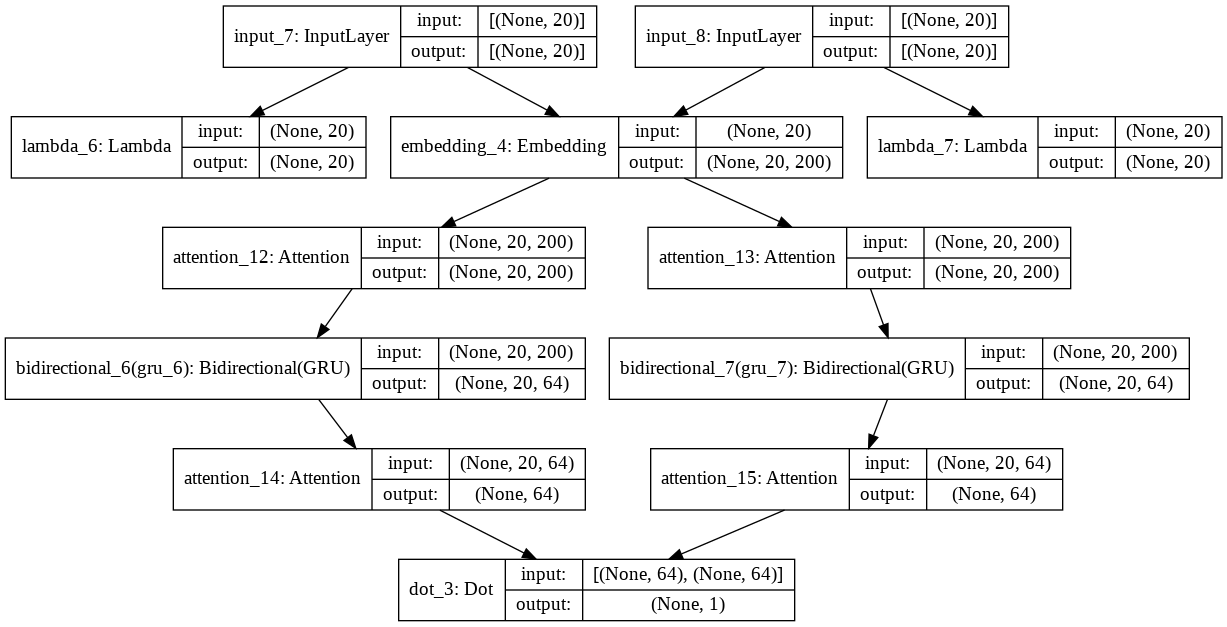

In [25]:
plot_model(model, "rnn_match.png", show_shapes=True)

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit([train_X1, train_X2], train_y1, validation_data=([valid_X1, valid_X2], valid_y1), epochs=1, batch_size=256, verbose=1)

2367/2367 [==============================] - 1189s 498ms/step - loss: 0.3762 - accuracy: 0.8399 - val_loss: 0.1488 - val_accuracy: 0.9613


In [28]:
loss, accuracy = model.evaluate([test_X1, test_X2], test_y1)
print("loss of the test data: {:.3f}".format(loss))
print("accuracy of the test data: {:.3f}".format(accuracy))

1052/1052 [==============================] - 24s 23ms/step - loss: 0.1553 - accuracy: 0.9619
loss of the test data: 0.155
accuracy of the test data: 0.962


In [29]:
model.save("rnn_match_model.h5")